In [ ]:
import numpy as np
from scipy.sparse import diags, kron, csr_matrix, csc_matrix
from scipy.sparse.linalg import spsolve, norm, inv, eigsh
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('text', usetex=True) # para usar latex en matplotlib

*Universidad de Chile*  
*Facultad de Ciencias Físicas y Matemáticas*  
*Departamento de Ingeniería Matemática*

**MA5307-1 Análisis Numérico de EDP: Teoría y Laboratorio**  
**Profesor:** Axel Osses  
**Auxiliares:** Tomás Banduc

# Laboratorio 1

**Objetivo General:** A través de esta sesión práctica, se busca que el estudiante aprenda a resolver problemas elípticos de EDP en dos-dimensiones aplicando el Método de Diferencias Finitas.

**Objetivo Particular:** Se resolverá la ecuación de Poisson en un cuadrado unitario. Además se estudiará la aproximación de su solución para condiciones de borde en dominios con curvatura, como es el caso del rectángulo perforado.

# Parte I


## Ecuación de Poisson en Dominio Cuadrado

Considere la ecuación del calor en estado estacionario sobre el cuadrado unitario:


\begin{align*}
(P)\quad\left\{
\begin{array}[c]{rll}
-\Delta u= & 0 & \text{sobre }\Omega=\left(  0,1\right)^{2}\\
u(x,0)= & 0 & \text{en }0\leq x\leq 1\\
u(x,1)= & g(x) & \text{en }0\leq x\leq 1\\
u(0,y)= & 0 & \text{en }0< y< 1\\
u(1,y)= & 0 & \text{en }0< y <1
\end{array}
\right.
\end{align*}

donde $g\in\mathcal{C}^1([0,1])$ cumple que $g(0)=g(1)=0$.

Sea $N\in\mathbb{N}$ y $\Omega_h$ el mallado equiespaciado del cuadrado unitario $\Omega$:

\begin{align*}
\Omega_{h}:=\left\{  \left(  x_{j},y_{k}\right)  \mid j,k\in\left\{
0,1,\ldots,N+1\right\}  \right\}, \quad x_j:=j\cdot h, \quad y_k:=k\cdot h
\end{align*}


Para aproximar el operador Laplaciano del problema de Poisson, se define el *Laplaciano Direcretizado* por 5 puntos como:

\begin{align*}
(\Delta_{h}U)_{j,k}=\dfrac{1}{h^{2}}\left(U_{j,k-1}+U_{j-1,k}-4U_{j,k}
+U_{j+1,k}+U_{j,k+1}
\right)
\end{align*}


Buscamos una solución $(u_{j,k})_{j,k\in\{0\,...,N+1\}}$ que cumpla la versión discretizada de $(P)$ inducida por el laplaciano anterior, de modo que $u_{j,k}\simeq u(x_j,y_k)$ para la solución única $u$ de $(P)$.


Tomando $g(x) = \sin(\pi x)$ se puede demostrar que la solución de esta ecuación está dada por:

$$u\left(  x,y\right)  =\dfrac{1}{\sinh\left(  \pi\right)}\cdot\sin\left( \pi x\right)   \sinh\left( \pi y\right) $$

### P1

> **(a)** Escriba dos funciones que calculen $\boldsymbol{A}_{h}$ y $\boldsymbol{b}_{h}$ asociadas al problema lineal equivalente del problema discreto. Las entradas para estas funciones deben ser $N$ y $g$.<br>
<br>
**(b)** Cree una función `solve` que, utilizando estas funciones, y las funciones auxiliares que necesite, entregue la solución aproximada $u_h$ del problema $(P)$.<br>
<br>
**Hint:** Le puede ser útil revisar la documentación del comando `kron` (disponible a través de `scipy.sparse`).

In [ ]:
def omega(N):
  puntos = np.linspace(0, 1, N + 2)  # Genera N+2 puntos entre 0 y 1
  X , Y = puntos, puntos
  return X, Y

def euclides(n:int, N:int) -> tuple[int,int]:
  """
  Dado n y N, te entrega los únicos j,k tal que n = (k-1)N + j.
  Indexación desde 0.
  """
  n += 1

  k = n//N + 1
  j = n%N
  if n%N ==0:
    k -= 1
    j += N

  j-=1
  k-=1
  return j, k

def Ah(N:int) -> sp.sparse:
  h = 1/(N+1)
  ##L4
  diag_1 = np.ones(N) # vector 1 de largo N
  diag_2 = np.ones(N-1) # vector 1 de largo N-1

  diag = np.array([-diag_2,
                  4*diag_1,
                  -diag_2],
                  dtype = object) # arreglo de vectores. Cuando la dimensión de las filas sea distinta, es importante que dtype = object
  offset = [-1,0,1] # posiciones respecto a la diagonal en que se ubicarán los vectores
  L4 = diags(diag, offset) # definir matriz sparse diagonal (type dia_matrix)

  ##Ah
  Ah_diag = kron(sp.sparse.identity(N), L4) # Diagonal de bloques L4

  diag2 = np.array([-diag_2,
                  -diag_2])
  offset2 = [-1,1]
  semi_diags = diags(diag2, offset2)
  Ah_semi_diags = sp.sparse.kron( semi_diags, sp.sparse.identity(N))
  A = Ah_diag + Ah_semi_diags
  return ((1/h)**2)*(A)

def bh(N:int, g:callable) -> np.array:
  h = 1/(N+1)
  x,_ = omega(N)

  b = np.zeros(N**2)

  for n in range(N**2):
    j, k = euclides(n,N)
    if k == N-1:
      b[n] = g(x[j])
  b *= (1/h)**2
  return b

def solve(N, f, g) -> sp.sparse:
    """ Resuelve el problema del laplaciano en 2D en (0,1)^2 con condiciones
    Dirichlet en el borde, usando una grilla uniforme de N puntos interiores, con paso h = 1/(N+1) en x e y.
    """
    A = Ah(N)
    b = bh(N,g)

    u = sp.sparse.linalg.spsolve(A,b)
    return u

### P2

> Resuelva la ecuación para $N\in\{10, 20, 30, 40, 50, 60, 70, ..., 100\}$, mostrando la evolución del error $L^2$ como función de $N$. Grafique la solución aproximada (en tres casos de su elección) y la solución analítica.<br> **Indicación**: Comente sus resultados.

Errores:
	N = 10 -> error = 0.12800317470572192
	N = 20 -> error = 0.10550706024271536
	N = 30 -> error = 0.09117526062059124
	N = 40 -> error = 0.0813153617414851
	N = 50 -> error = 0.07404913836294137
	N = 60 -> error = 0.06842142466749794
	N = 70 -> error = 0.06390113024987931
	N = 80 -> error = 0.06016891730096742
	N = 90 -> error = 0.05702044385339719
	N = 100 -> error = 0.05431832343703341


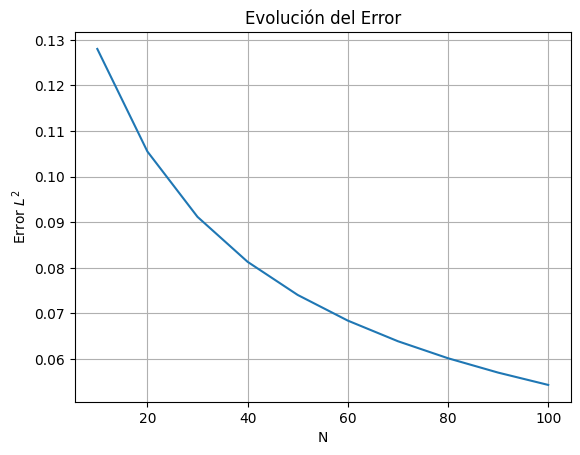

In [ ]:
def u(x,y):
  return np.sin(np.pi*x)*np.sinh(np.pi*y)/np.sinh(np.pi)

def omega_v(N):
  grid = []
  puntos = np.linspace(0, 1, N + 2)  # Genera N+2 puntos entre 0 y 1
  for i in range(N+2):
    for j in range(N+2):
      grid.append((puntos[j],puntos[i]))
  return np.array(grid)

def omega_v_interior(N):
  grid = []
  puntos = np.linspace(0, 1, N + 2)  # Genera N+2 puntos entre 0 y 1
  for i in range(1,N+1):  #sólo considero el interior
    for j in range(1,N+1):#sólo considero el interior
      grid.append((puntos[j],puntos[i]))
  return np.array(grid)

def calcular_error(N,f,g):
    X,Y = omega(N)
    u_calculado = solve(N,f,g)
    u_real = np.array([u(v[0],v[1]) for v in omega_v_interior(N)])
    error = np.linalg.norm(u_calculado - u_real, 2)/np.sqrt(N)
    return error

f, g = lambda x: 0, lambda x: np.sin(x * np.pi)
errores = [calcular_error(N,f,g) for N in np.linspace(10,100,10, dtype=int)]

print("Errores:")
for error, N in zip(errores, np.linspace(10,100,10, dtype=int)):
  print(f"\tN = {N} -> error = {error}")

plt.plot(np.linspace(10,100,10, dtype=int),errores)

plt.title("Evolución del Error")
plt.xlabel("N")
plt.ylabel(r"Error $L^2$")
plt.grid()

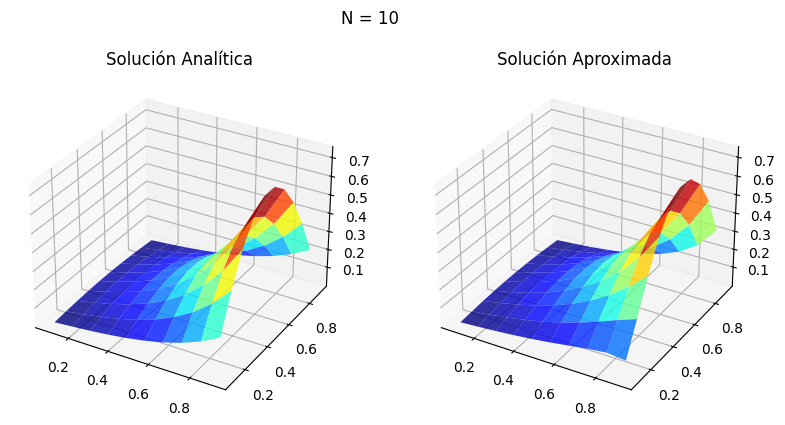

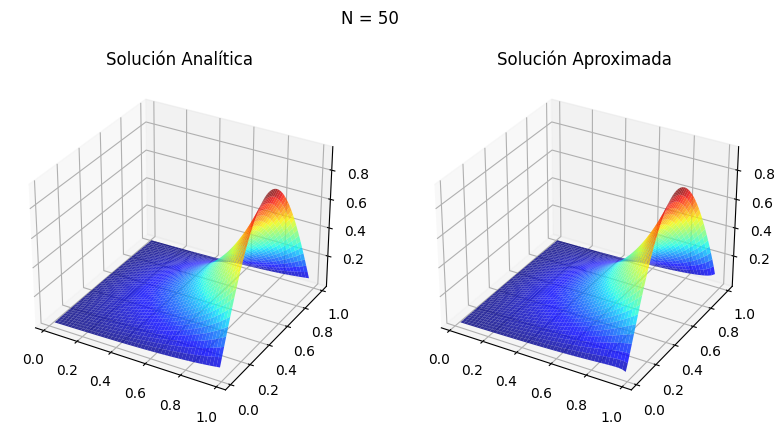

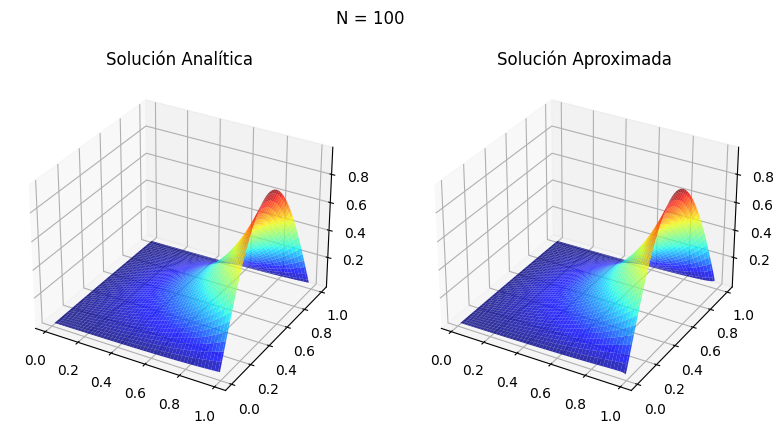

In [ ]:
for N in (10,50,100):
  u_real_grid = np.array([u(v[0],v[1]) for v in omega_v_interior(N)]).reshape((N,N))
  u_calculado_grid = solve(N,f,g).reshape((N,N))

  puntos = np.linspace(0, 1, N+2 )[1:-1]
  X, Y = np.meshgrid(puntos, puntos, indexing = 'ij')

  fig = plt.figure(figsize=plt.figaspect(0.5))
  fig.suptitle(f"N = {N}")

  # =============
  # First subplot
  # =============
  ax = fig.add_subplot(1, 2, 1, projection='3d')

  # plot a 3D surface like in the example mplot3d/surface3d_demo

  surf = ax.plot_surface(X, Y,  u_real_grid, alpha= 0.8, cmap='jet')
  ax.set_title("Solución Analítica")
  # ==============
  # Second subplot
  # ==============

  ax = fig.add_subplot(1, 2, 2, projection='3d')

  # plot a 3D wireframe like in the example mplot3d/wire3d_demo
  ax.plot_surface(X, Y,  u_calculado_grid, alpha= 0.8, cmap='jet')
  ax.set_title("Solución Aproximada")

  plt.show()


**Comentario**: De la evolución del error podemos concluir que tal como se esperaría, la solución calculada es más cercana a la real cuanto mayor es el nivel de discretización con el cual se calcula. Sin embargo la reducción del error no es lineal, y cuanto mayor es la discretización, menor es la mejora en términos del error $L^{2}$ .

Los gráficos permiten corroborar que la solución no sólo es cercana en términos de error promedio, sino que tiene una forma similar.

Sean $p\in\left[  1,+\infty\right]  $ y $\boldsymbol{A}\in\mathbb{R}^{N\times N}$. Se define la norma inducida $p$ de $\boldsymbol{A}$ como:

\begin{align*}
\left\Vert \boldsymbol{A}\right\Vert _{p}=\sup\limits_{\boldsymbol{x\in}\mathbb{R}^{N}\setminus\left\{  \boldsymbol{0}\right\}  }\dfrac{\left\Vert\boldsymbol{Ax}\right\Vert _{p}}{\left\Vert \boldsymbol{x}\right\Vert_{p}}
\end{align*}

Si $\boldsymbol{A}$ es invertible, se define el número de condición en norma inducida $p$ como:

\begin{align*}\operatorname{cond}_{p}\left(  \boldsymbol{A}\right)  =\left\Vert
\boldsymbol{A}\right\Vert _{p}\left\Vert \boldsymbol{A}^{-1}\right\Vert _{p}\end{align*}

### P3
> Estudie el condicionamiento en norma $2$ de la Matriz $A_h$.

**Observación:** En el caso particular de $\boldsymbol{A}_{h}$, dado que la matriz es simétrica, su número de condición en norma $2$ inducida puede calcularse mediante sus valores propios de mayor y menor magnitud:

\begin{align*}
\operatorname{cond}_{2}\left(  \boldsymbol{A}_{h}\right)  =\dfrac{\lambda_{\max,h}\left(  \boldsymbol{A}_{h}\right)  }{\lambda_{\min,h}\left(\boldsymbol{A}_{h}\right)}
\end{align*}

donde $\lambda_{\max,h}\left(  \boldsymbol{A}_{h}\right) :=\max\left\{\left\vert \lambda\right\vert \mid\lambda\in\sigma\left(  \boldsymbol{A}_{h}\right)  \right\}  $ y $\lambda_{\min,h}\left(  \boldsymbol{A}_{h}\right)
:=\min\left\{  \left\vert \lambda\right\vert \mid\lambda\in\sigma\left(\boldsymbol{A}_{h}\right)  \right\}  $.

 N  Formaula vp  Formula norma   Diferencia
 1     1.000000       1.000000 0.000000e+00
 2     3.000000       3.000000 3.108624e-15
 3     5.828427       5.828427 1.776357e-15
 4     9.472136       9.472136 7.105427e-15
 5    13.928203      13.928203 1.065814e-14
 6    19.195669      19.195669 1.989520e-13
 7    25.274142      25.274142 1.456613e-13
 8    32.163437      32.163437 2.415845e-13
 9    39.863458      39.863458 1.136868e-13
10    48.374150      48.374150 2.557954e-13
11    57.695481      57.695481 1.953993e-12
12    67.827429      67.827429 5.684342e-14
13    78.769982      78.769982 1.946887e-12
14    90.523131      90.523131 5.400125e-13
15   103.086869     103.086869 7.275958e-12
16   116.461192     116.461192 4.050094e-12
17   130.646096     130.646096 1.242029e-11
18   145.641579     145.641579 1.239187e-11
19   161.447639     161.447639 1.614353e-11
20   178.064275     178.064275 2.046363e-12
21   195.491485     195.491485 2.867750e-11
22   213.729269     213.729269 1

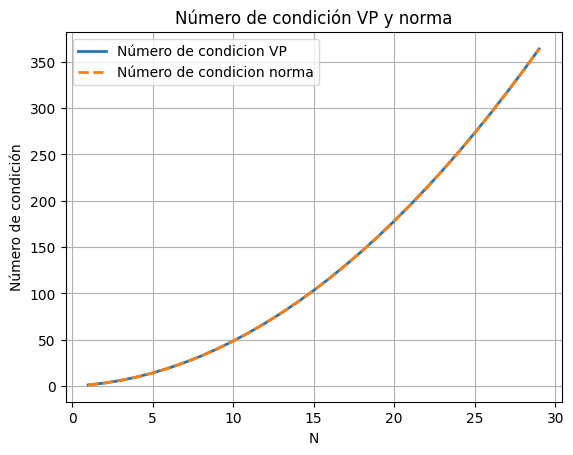

In [20]:
def cond_2_sparse(A:np.array):
  """
  Calcula el numero de condicionamiento en norma inducida 2
  para una matriz sparse simetrica A.
  Se obtiene como el valor propio de mayor módulo dividido por el de menor módulo

  Input:
  - A matriz sparse simetrica

  Documentacion de eigsh:
  https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.sparse.linalg.eigsh.html
  """
  valores_propios, vectores_propios = np.linalg.eig(A)
  max_eigenvalue = np.max(np.abs(valores_propios))
  min_eigenvalue = np.min(np.abs(valores_propios))
  cond = max_eigenvalue/min_eigenvalue

  return cond

#discretizaciones = np.linspace(1,30,4)
#condicionamientos = [cond_2_sparse(Ah(int(N)).todense()) for N in discretizaciones]
#print('\n'.join(
    #[f'N = {N} -> cond_2 = {cond}' for N,cond in zip(discretizaciones, condicionamientos)]
#))

import pandas as pd

formula_eig = []
formula_real = []
M = 30
for N in range(1,M):
  A = Ah(N)

  A = A.todense()

  try:
    cond_2_eig = np.real(cond_2_sparse(A))
  except Exception as e:
    cond_2_eig = np.nan
    #print(Ahx(N))
    #print(np.where(np.isnan(Ahx(N))))
    #print(N)
    #print(e)
  formula_eig.append(cond_2_eig)

  A_inv = np.linalg.inv(A)
  cond_2_real = np.linalg.norm(A, ord=2) * np.linalg.norm(A_inv, ord=2)
  formula_real.append(cond_2_real)

diferencia = [abs(eig - norm) for eig, norm in zip(formula_eig,formula_real)]
numero_cond_dict = {"N": list(range(1,M)), "Formaula vp": formula_eig, "Formula norma": formula_real, "Diferencia": diferencia}
numero_cond_df = pd.DataFrame(numero_cond_dict)

print(numero_cond_df.to_string(index=False))

plt.plot(range(1, M), formula_eig, label='Número de condicion VP', linewidth=2)
plt.plot(range(1, M), formula_real, label='Número de condicion norma', linestyle="--", linewidth=2)
plt.xlabel('N')
plt.ylabel('Número de condición')
plt.title('Número de condición VP y norma')
plt.legend()
plt.grid(True)
plt.show()



# Parte II

## Ecuación de Poisson en Dominio Perforado

Para $\Omega = (0, 1)^2\backslash B ((0.5, 0.5), 0.3)$, considere el siguiente problema:

\begin{align*}
\left(  P \right)  \left\{
\begin{array}
[c]{rl}
-\Delta u(x,y)=&0,  & \text{si }(x,y)\text{ en }\Omega \\
u(x,y)=&g(x,y), & \text{si} (x,y)\text{ en }\partial\Omega
\end{array}
\right.
\end{align*}

donde $g$ viene dada por:

\begin{align*}
g\left(  x,y\right)  =\left\{
\begin{array}
[c]{rl}
2, &\text{si }(x,y) \in \partial (0,1)^2 \\
0, &\text{si }(x,y) \in \partial B ((0.5, 0.5), 0.3)
\end{array}
\right.
\end{align*}






### P1

> Programe una función que reciba un punto de la malla $(x_j , y_k)$ y entregue como resultado $1$ si es un punto interior al cual se le puede calcular $\Delta u$ con la aproximación utilizada en la fórmula de $5$ puntos, y $0$ si no.

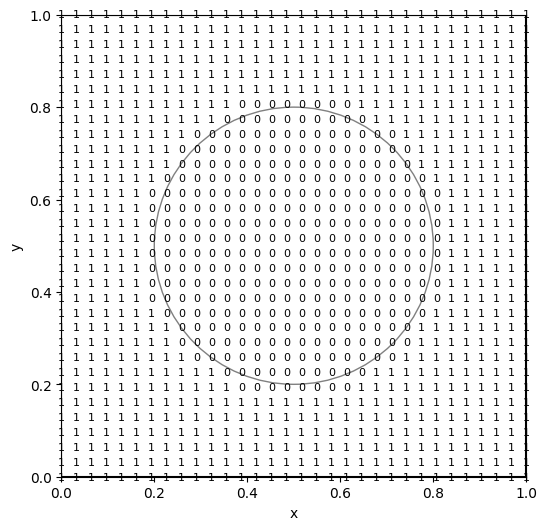

In [ ]:
def en_el_hoyo(x:float,y:float) -> bool:
  """
  Entrega el valor de verdad de la proposición '(x,y) está en el hoyo'.
  """
  return (x-0.5)**2 + (y-0.5)**2 <= 0.09

def stencilx(x:float,y:float,N:int) -> int:
  """
  Recibe un punto (x,y) en el cuadrado unitario, lo proyecta al mallado, y entrega 0 si el punto (proyectado) tiene vecinos en el eje x en el hoyo y 1 en caso contrario.
  """
  assert 0<=x and 0<=y and x<=1 and y<=1, f"({x},{y}) no se ecuentra en el cuadrado unitario."
  X,Y= omega(N)
  x = min(X,key=lambda t: abs(t-x))
  y = min(Y,key=lambda t: abs(t-y))
  j = np.where(X == x)[0][0]
  k = np.where(Y == y)[0][0]
  if j==0 or j==len(X)-1 or k==0 or k==len(Y)-1:
    return 1
  if en_el_hoyo(X[j],Y[k]) or en_el_hoyo(X[j-1],Y[k]) or en_el_hoyo(X[j+1],Y[k]):
    return 0
  return 1

def stencily(x:float,y:float,N:int) -> int:
  """
  Recibe un punto (x,y) en el cuadrado unitario, lo proyecta al mallado, y entrega 0 si el punto (proyectado) tiene vecinos en el eje y en el hoyo y 1 en caso contrario.
  """
  assert 0<=x and 0<=y and x<=1 and y<=1, f"({x},{y}) no se ecuentra en el cuadrado unitario."
  X,Y= omega(N)
  x = min(X,key=lambda t: abs(t-x))
  y = min(Y,key=lambda t: abs(t-y))
  j = np.where(X == x)[0][0]
  k = np.where(Y == y)[0][0]
  if j==0 or j==len(X)-1 or k==0 or k==len(Y)-1:
    return 1
  if en_el_hoyo(X[j],Y[k]) or en_el_hoyo(X[j],Y[k-1]) or en_el_hoyo(X[j],Y[k+1]):
    return 0
  return 1

def stencil(x,y,N):
  result = min(stencilx(x,y,N),stencily(x,y,N))
  return result


"""
Un LLM asistió con el siguiente plot.
"""

# Número de puntos por eje
n_puntos = 30

# Genera puntos con espaciado uniforme
x,y = omega(n_puntos)
x_puntos, y_puntos = np.meshgrid(x,y)
x_puntos = x_puntos.flatten()
y_puntos = y_puntos.flatten()

# Determina el color de cada punto según la función stencil
colores = [stencil(x, y, n_puntos) for x, y in zip(x_puntos, y_puntos)]

# Gráfica del cuadrado unitario
plt.figure(figsize=(6, 6))
plt.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], 'k-', label='Cuadrado Unitario')  # Cuadrado unitario

# Gráfica del círculo
circulo = plt.Circle((0.5, 0.5), 0.3, color='gray', fill=False)
plt.gca().add_patch(circulo)

# Gráfica de dispersión de los puntos
for x, y, c in zip(x_puntos, y_puntos, colores):
    etiqueta = '1' if c == 1 else '0'
    plt.text(x, y, etiqueta, color='black', fontsize=8, ha='center', va='center')

# Establece límites y etiquetas de los ejes
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.ylabel('y')

# Muestra la gráfica
plt.show()


### P2

> Asuma que la matriz del sistema es de la forma $A_h = A_{h,x} + A_{h,y}$, donde $A_{h,x}$ tiene los coeficientes adecuados
para la aproximación de la derivada parcial según $x$, y $A_{h,y}$ los valores necesarios para estimar la derivada parcial en $y$. Encuentre la forma
que deben tener $A_{h,x}$ y $A_{h,y}$ y elabore funciones que calculen dichas matrices. <br> <br>
**Hint 1:** Se sugiere segmentar el problema de programación lo más posible: Puede usar las funciones auxiliares que estime convenientes.<br>
**Hint 2:** Tenga en cuenta las fórmulas explícitas de los coeficientes $\alpha,\beta$ y $\gamma$ de la interpolación del mallado vista para dominio perforado.


In [ ]:
def distancia_hoyox(x,y):
  return abs(x- np.sqrt(0.09 - y**2))

def distancia_hoyox_(x,y):
  x_p = min([np.sqrt(0.3**2 - y**2), -np.sqrt(0.3**2 - y**2)], key=lambda t: abs(x-t))
  return abs(x_p - x)

  #dist = abs(i*h - np.sqrt(0.09 - (j*h)**2))

def Ahx(N):
    h = 1/(N+1)
    diag1 = np.ones(N)
    diag2 = np.ones(N-1)
    k = np.array([-diag2,2*diag1,-diag2] ,dtype = object)
    offset = [-1,0,1]
    L = diags(k,offset)
    Ax = kron(np.identity(N),L).todense()
    Ax = Ax * (1/h)**2
    #reparamos los valores de los puntos que si son interiores pero tienen vecinos problematicos
    for j in range(N-1):
        for i in range(N-1):
            if not en_el_hoyo((i+1)*h,(j+1)*h):
                if stencilx((i+1)*h,(j+1)*h,N) == 0:
                    x_p = min([np.sqrt(0.3**2 - ((j+1)*h-0.5)**2) + 0.5, -np.sqrt(0.3**2 - ((j+1)*h-0.5)**2) + 0.5], key=lambda t: abs((i+1)*h-t))
                    dist = abs(x_p - (i+1)*h)
                    alpha = 2/(h**2 + h*dist)
                    gamma = 2 / (h*dist + dist**2)
                    beta =  -alpha - gamma
                    if (i+1)*h <= 0.5:
                        if i != 0:
                            Ax[j*N+i,j*N+i-1] = alpha
                        Ax[j*N+i,j*N+i] = beta
                        Ax[j*N+i,j*N+i+1] = 0
                    else:
                        if i != N-1:
                            Ax[j*N + i,j*N + i+1] = alpha
                        Ax[j*N + i,j*N + i] = beta
                        Ax[j*N+i,j*N+i-1] = 0
            else:
                Ax[j*N+i,j*N+i] = 0.0000001
                Ax[j*N+i,j*N+i-1] = 0
                Ax[j*N+i,j*N+i+1] = 0
    return Ax

def Ahy(N):
    h = 1/(N+1)
    diag = np.ones(N-1)
    k = np.array([-1,0,-1])
    I = np.array([-diag,np.zeros(N),-diag] ,dtype = object)
    kron_prod_y = diags(I,[-1,0,1])
    Ay_1 = kron(kron_prod_y,np.identity(N))


    L = np.identity(N)*2
    Ay_2 = kron(np.identity(N),L)

    Ay = Ay_1 + Ay_2
    Ay = Ay.todense() * (1/h)**2

    #reparamos los valores de los puntos que si son interiores pero tienen vecinos problematicos
    for j in range(N-1):
        for i in range(N-1):
            if not en_el_hoyo((i+1)*h,(j+1)*h):
                if stencily((i+1)*h ,(j+1)*h,N ) == 0:
                    y_p = min([np.sqrt(0.3**2 - ((i+1)*h - 0.5)**2) + 0.5, -np.sqrt(0.3**2 - ((i+1)*h - 0.5)**2) + 0.5], key=lambda t: abs((j+1)*h-t))
                    dist = abs(y_p - (j+1)*h)
                    alpha = 2/(h **2 + h* dist)
                    gamma = 2 / (h* dist + dist**2)
                    beta =  - alpha - gamma
                    if (j+1)*h  <= 0.5:
                        if j*N+i>=N:
                            Ay[j*N + i,j*N+i-N] = alpha
                        Ay[j*N + i,j*N+i] = beta
                        Ay[j*N + i,j*N+i+N] = 0
                    else:
                        if j*N+i < (N**2 - N):
                            Ay[j*N + i,j*N+i+N] = alpha
                        Ay[j*N + i,j*N+i] = beta
                        Ay[j*N + i,j*N+i-N] = 0
            else:
                Ay[j*N+i,j*N+i] = 0.00000001
                Ay[j*N+i,j*N+i-N] = 0
                Ay[j*N+i,j*N+i+N] = 0
    return Ay

### P3
> Escriba una función que calcule $b_h$ adaptado a este caso.

In [ ]:
def bh(N):
  b = np.zeros(N**2)
  h = (1/N+1)
  for n in range(N**2):
    columna, fila = n//N, n%N
    if columna in (0,N-1) or fila in (0,N-1):
      b[n] = 2
  b *= (1/h)**2
  return b
bh(5).reshape((5,5))


array([[1.38888889, 1.38888889, 1.38888889, 1.38888889, 1.38888889],
       [1.38888889, 0.        , 0.        , 0.        , 1.38888889],
       [1.38888889, 0.        , 0.        , 0.        , 1.38888889],
       [1.38888889, 0.        , 0.        , 0.        , 1.38888889],
       [1.38888889, 1.38888889, 1.38888889, 1.38888889, 1.38888889]])

### P4
>Resuelva el sistema $A_h u_h = b_h$ asociado a la discretización del dominio perforado, grafique la solución aproximada para $N\in\{10, 20, 30, 40, 50\}$ y muestre la evolución del error en norma $L^2$ asociado.
<br> **Indicación:** Comente sus resultados.

In [ ]:
def solve2(N):
    h=(1/N+1)
    A =(1/h)**2*( Ahx(N) + Ahy(N))
    b = bh(N)
    u = sp.sparse.linalg.spsolve(A,b)
    return u


/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


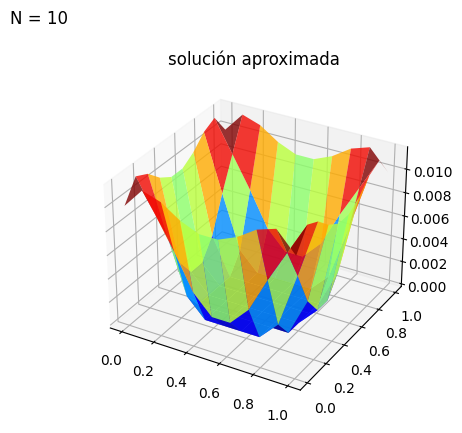

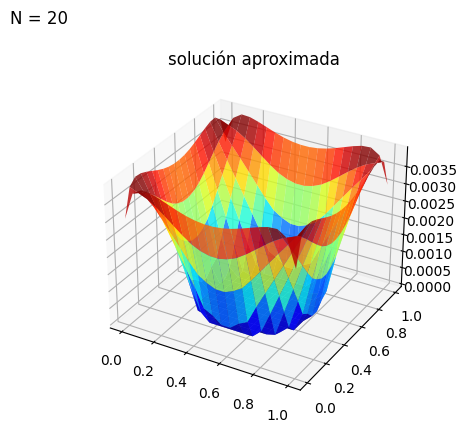

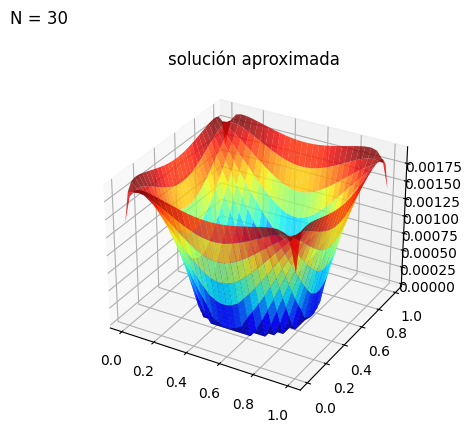

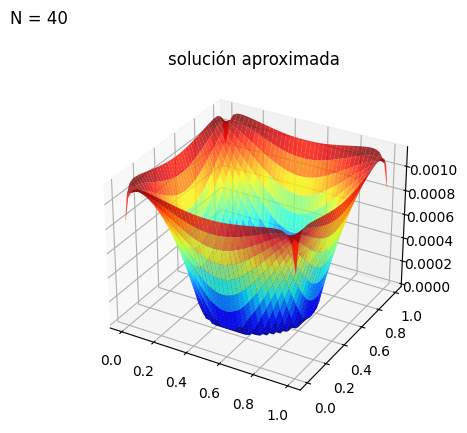

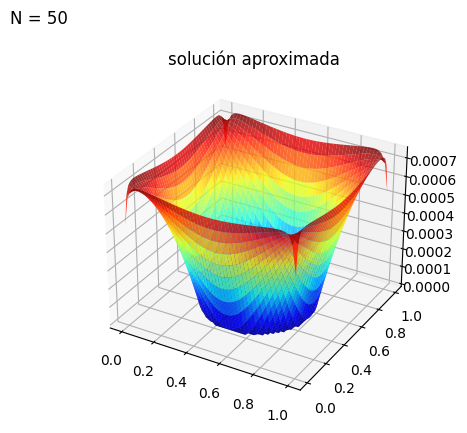

In [ ]:
for N in (10,20, 30, 40, 50):
  u_calculado_grid = solve2(N).reshape((N,N))

  puntos = np.linspace(0, 1, N )  # Genera N+2 puntos entre 0 y 1
  X, Y = np.meshgrid(puntos, puntos, indexing = 'ij')

  fig = plt.figure(figsize=plt.figaspect(0.5))
  fig.suptitle(f"N = {N}")

  ax = fig.add_subplot(1, 2, 2, projection='3d')

  # plot a 3D wireframe like in the example mplot3d/wire3d_demo
  ax.plot_surface(X, Y,  u_calculado_grid, alpha= 0.8, cmap='jet')
  ax.set_title("solución aproximada")

  plt.show()

### P5
>Muestre qué sucede con el condicionamiento de la matriz utilizando la fórmula de valores propios de la Parte I. ¿Es dicha fórmula válida en este caso? ¿Cómo adaptaría su código para $f\neq 0$?

<ipython-input-14-942e8fc0f392>:27: RuntimeWarning: divide by zero encountered in scalar divide
  gamma = 2 / (h*dist + dist**2)
<ipython-input-14-942e8fc0f392>:68: RuntimeWarning: divide by zero encountered in scalar divide
  gamma = 2 / (h* dist + dist**2)


 N  Formaula vp  Formula norma   Diferencia
 1 1.000000e+00   1.000000e+00 0.000000e+00
 2 4.429811e+08   4.904571e+08 4.747602e+07
 3 1.728130e+09   1.932833e+09 2.047035e+08
 4 5.084272e+09   5.716436e+09 6.321641e+08
 5 2.723321e+09   3.078179e+09 3.548577e+08
 6 5.878122e+10   6.297376e+10 4.192545e+09
 7 3.435515e+09   4.491558e+09 1.056044e+09
 8 8.767846e+09   9.914533e+09 1.146687e+09
 9          NaN            NaN          NaN
10 1.250218e+10   1.318065e+10 6.784648e+08
11 6.534472e+11   6.534719e+11 2.468775e+07
12 1.079969e+10   1.213741e+10 1.337719e+09
13 1.174918e+11   1.177175e+11 2.257849e+08
14 1.447488e+11   1.448744e+11 1.256173e+08
15 3.160895e+10   3.298405e+10 1.375102e+09
16 1.483022e+11   1.486830e+11 3.807949e+08
17 3.105378e+10   3.302477e+10 1.970981e+09
18 1.050015e+13   1.050016e+13 9.731052e+06
19          NaN            NaN          NaN
20 1.760749e+11   1.768135e+11 7.385450e+08
21 1.071537e+11   1.084799e+11 1.326236e+09
22 1.913654e+11   1.923048e+11 9

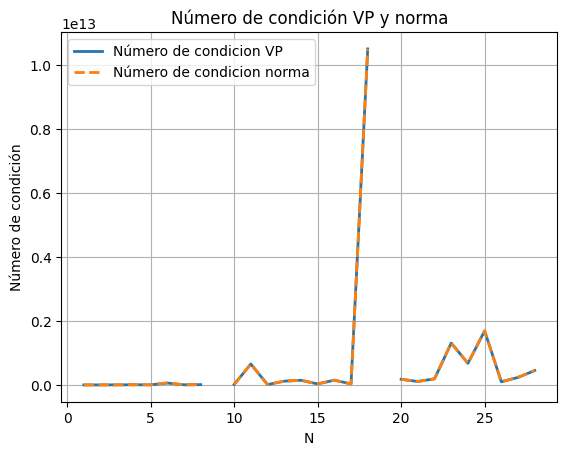

In [ ]:
import pandas as pd

formula_eig = []
formula_real = []
M = 30
for N in range(1,M):
  A = Ahx(N) + Ahy(N)

  #A = A.todense()

  try:
    cond_2_eig = np.real(cond_2_sparse(A))
  except Exception as e:
    cond_2_eig = np.nan
    #print(Ahx(N))
    #print(np.where(np.isnan(Ahx(N))))
    #print(N)
    #print(e)
  formula_eig.append(cond_2_eig)

  A_inv = np.linalg.inv(A)
  cond_2_real = np.linalg.norm(A, ord=2) * np.linalg.norm(A_inv, ord=2)
  formula_real.append(cond_2_real)

diferencia = [abs(eig - norm) for eig, norm in zip(formula_eig,formula_real)]
numero_cond_dict = {"N": list(range(1,M)), "Formaula vp": formula_eig, "Formula norma": formula_real, "Diferencia": diferencia}
numero_cond_df = pd.DataFrame(numero_cond_dict)

print(numero_cond_df.to_string(index=False))

plt.plot(range(1, M), formula_eig, label='Número de condicion VP', linewidth=2)
plt.plot(range(1, M), formula_real, label='Número de condicion norma', linestyle="--", linewidth=2)
plt.xlabel('N')
plt.ylabel('Número de condición')
plt.title('Número de condición VP y norma')
plt.legend()
plt.grid(True)
plt.show()